In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.exposure import match_histograms
from samgeo import SamGeo
import os

In [ ]:
class ImageAnalysis():

    # Intialising parameters
    def __init__(self, img1, img2, threshold = 50):
        
        self.image_1 = img1
        self.image_2 = img2
        self.thresh = threshold
        
    # Processing images
    def image_preprocessing(self):
        img1, img2 = self.image_1, self.image_2

        # Convert from BGR to RGB
        img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

        # Histogram matching (B to A)
        matched = match_histograms(img2_rgb, img1_rgb, channel_axis=-1).astype(np.uint8)

        # CLAHE (Contrast enhancement)
        def apply_clahe_rgb(image):
            lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)

            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            cl = clahe.apply(l)

            merged = cv2.merge((cl, a, b))
            return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

        img1_clahe = apply_clahe_rgb(img1_rgb)
        img2_clahe = apply_clahe_rgb(matched)

        return img1_clahe, img2_clahe
    
    # Feature matching for image alignment
    def feature_matching(self):
        img1, img2 = self.image_preprocessing()

        # Cropping the image by the borders
        def cropping_borders(image, threshold= 50):
            top = bottom = left = right = threshold

            # Get image dimensions
            height, width = image.shape[:2]

            # Crop the image
            cropped_image = image[top:height-bottom, left:width-right]

            return cropped_image

        # Aligning images
        def processing(img1, img2):
            # # Convert to grayscale
            gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
            gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

            # Detecting ORB features
            orb = cv2.ORB_create(5000)
            kp1, des1 = orb.detectAndCompute(gray1, None)
            kp2, des2 = orb.detectAndCompute(gray2, None)

            # Using Brute-Force Matcher
            bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
            matches = bf.match(des1, des2)
            matches = sorted(matches, key=lambda x: x.distance)

            # Using good matches to compute homography
            num_good_matches = int(len(matches) * 0.15)
            good_matches = matches[:num_good_matches]

            src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

            h_graph, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

            # Warpping the image 2 to align with image 1
            height, width = img1.shape[:2]
            aligned_img2 = cv2.warpPerspective(img2, h_graph, (width, height))
            
            img1 = cropping_borders(img1)
            aligned_img2 = cropping_borders(aligned_img2)

            # difference in image to visualize changes
            diff = cv2.absdiff(img1, aligned_img2)
            gray_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
            _, thresh_diff = cv2.threshold(gray_diff, 25, 255, cv2.THRESH_BINARY)

            return img1, aligned_img2, thresh_diff
        
        img1, img2, mask = processing(img1, img2)

        return img1, img2, mask
    
    # Highlighting the changes
    def highlight_diff(self):
        img1, img2, mask = self.feature_matching()

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        contour_mask = np.zeros_like(mask)

        # Draw the contours as white on the black image
        cv2.drawContours(contour_mask, contours, -1, color=255, thickness=cv2.FILLED)

        # Draw contours on a copy of image1
        img2_with_contours = img2.copy()
        cv2.drawContours(img2_with_contours, contours, -1, (255, 0, 0), 2) # Green contours, thickness 2

        return img1, img2, img2_with_contours, mask, contour_mask
    
    # Generating segmentation map
    def segmentation_predict(self, image, mask_name):

        sam = SamGeo(
            model_type="vit_b",  # or 'vit_l', 'vit_b' depending on accuracy/speed needs
            checkpoint="sam_vit_h_4b8939.pth",  # path to SAM checkpoint
        )

        # Predict masks for the whole image (automatic mask generator)
        sam.generate(image, output=f"{mask_name}.jpg", foreground=False, unique=True)

d:\yolo11\env\Lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


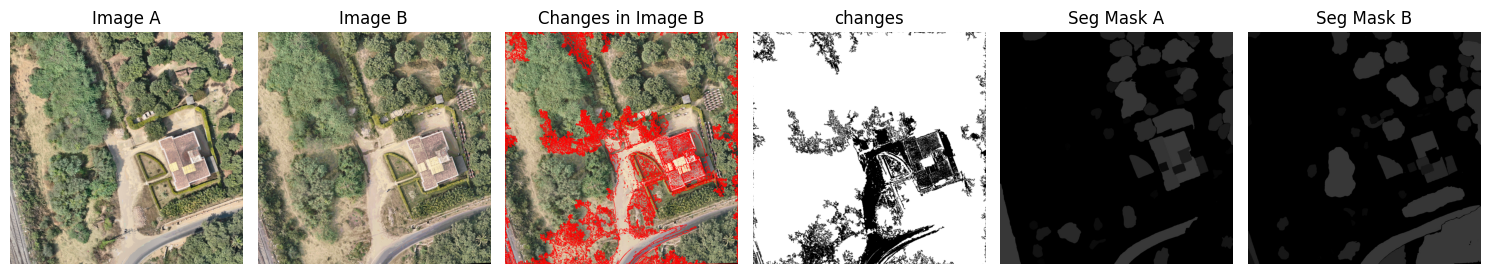

In [ ]:
# Images path
img_path_1 = r'A (2).png'
img_path_2 = r'B (2).png'

# Segment map paths
seg_mask1_path = r'mask_1.jpg'
seg_mask2_path = r'mask_2.jpg'

# Rows and columns for visualisation
row, cols = 1, 6

# Loading images
img1 = cv2.imread(img_path_1, cv2.IMREAD_COLOR)
img2 = cv2.imread(img_path_2, cv2.IMREAD_COLOR)

# Creating class object
analysis = ImageAnalysis(img1, img2, 50)
img1, img2, highlighted_img, mask, changes = analysis.highlight_diff()

segment_image_1 = analysis.segmentation_predict(img1, "mask_1")
segment_image_2 = analysis.segmentation_predict(img2, "mask_2")

# In case the segmentation maps exist loading maps
if os.path.exists(seg_mask1_path) and os.path.exists(seg_mask2_path):
    seg_mask_1 = cv2.imread(seg_mask1_path, cv2.IMREAD_COLOR)  # Reference image
    seg_mask_2 = cv2.imread(seg_mask2_path, cv2.IMREAD_COLOR)  # Image to align


# Visualization
plt.figure(figsize=(15, 10))

plt.subplot(row, cols, 1); plt.imshow(img1); plt.title('Image A'); plt.axis('off')
plt.subplot(row, cols, 2); plt.imshow(img2); plt.title('Image B'); plt.axis('off')
plt.subplot(row, cols, 3); plt.imshow(highlighted_img); plt.title('Changes in Image B'); plt.axis('off')
plt.subplot(row, cols, 4); plt.imshow(changes, cmap= 'grey'); plt.title('changes'); plt.axis('off')
plt.subplot(row, cols, 5); plt.imshow(seg_mask_1, cmap= 'grey'); plt.title('Seg Mask A'); plt.axis('off')
plt.subplot(row, cols, 6); plt.imshow(seg_mask_2, cmap= 'grey'); plt.title('Seg Mask B'); plt.axis('off')

plt.tight_layout()
plt.show()
